In [32]:
import sklearn
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap


In [15]:
PENGUIN_DATASET = '../data/penguins_final_with_era5.csv'
penguin_df = pd.read_csv(PENGUIN_DATASET)

penguin_df.columns

Index(['Unnamed: 0', 'track_id', 'date_gmt', 'latitude_mean', 'longitude_mean',
       'lat_colony_mean', 'lon_colony_mean', 'km_to_colony_mean',
       'km_since_last_measure_mean', 'delta_km_north_mean',
       'delta_km_south_mean', 'delta_km_east_mean', 'delta_km_west_mean',
       'minutes_since_last_measure_mean', 'latitude_std', 'longitude_std',
       'lat_colony_std', 'lon_colony_std', 'km_to_colony_std',
       'km_since_last_measure_std', 'delta_km_north_std', 'delta_km_south_std',
       'delta_km_east_std', 'delta_km_west_std',
       'minutes_since_last_measure_std', 'latitude_min', 'longitude_min',
       'lat_colony_min', 'lon_colony_min', 'km_to_colony_min',
       'km_since_last_measure_min', 'delta_km_north_min', 'delta_km_south_min',
       'delta_km_east_min', 'delta_km_west_min',
       'minutes_since_last_measure_min', 'latitude_max', 'longitude_max',
       'lat_colony_max', 'lon_colony_max', 'km_to_colony_max',
       'km_since_last_measure_max', 'delta_km_nort

In [16]:
# define used colonies:
species = penguin_df['common_name'].unique()

available_years = [str(x) for x in range(1996, 2018)]
available_years = np.array(available_years)
penguin_df['date_gmt'] = pd.to_datetime(penguin_df['date_gmt'])
penguin_df['year'] = penguin_df['date_gmt'].dt.year.astype(str)
sufficient_pairs = []

for specie in species:
    colonies_with_data = []
    for colony in penguin_df[penguin_df['common_name'] == specie]['colony_name'].unique():
        years_with_data = penguin_df[(penguin_df['common_name'] == specie) & (penguin_df['colony_name'] == colony)]['year'].unique()
        if len(years_with_data) >= 8:
            colonies_with_data.append(colony)
    if colonies_with_data:
        sufficient_pairs.append({'specie': specie, 'colonies': colonies_with_data})

print(sufficient_pairs)

[{'specie': 'Adelie Penguin', 'colonies': ['Admiralty Bay']}, {'specie': 'Chinstrap Penguin', 'colonies': ['Admiralty Bay', 'Cape Shirreff']}, {'specie': 'Gentoo Penguin', 'colonies': ['Admiralty Bay', 'Cape Shirreff']}]


In [17]:
# filter df for species
adelie = penguin_df[(penguin_df['common_name'] == 'Adelie Penguin')]
chinstrap  = penguin_df[(penguin_df['common_name'] == 'Chinstrap Penguin')]
gentoo = penguin_df[(penguin_df['common_name'] == 'Gentoo Penguin')]

In [18]:
def data_prep(df):
    df['date_gmt'] = pd.to_datetime(df['date_gmt'])
    df = df.sort_values(by='date_gmt')

    # Feature Engineering
    df['day_of_year'] = df['date_gmt'].dt.dayofyear
    df['week_of_year'] = df['date_gmt'].dt.isocalendar().week
    df['month'] = df['date_gmt'].dt.month

    # Create lag features for 'tp' and 't2m'
    for lag in range(1, 4):
        df[f'tp_lag_{lag}'] = df['tp'].shift(lag)
        df[f't2m_lag_{lag}'] = df['t2m'].shift(lag)

    # Cyclical features for temporal variables
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.0)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.0)
    df['week_of_year_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52.0)
    df['week_of_year_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52.0)

    # Add lag features for additional variables
    for lag in range(1, 4):
        df[f'sst_lag_{lag}'] = df['sst'].shift(lag)
        df[f'siconc_lag_{lag}'] = df['siconc'].shift(lag)
        df[f'sd_lag_{lag}'] = df['sd'].shift(lag)
        df[f'rsn_lag_{lag}'] = df['rsn'].shift(lag)
        df[f'avg_smr_lag_{lag}'] = df['avg_smr'].shift(lag)

    # Rolling averages and cumulative sums for additional variables
    df['sst_rolling_7'] = df['sst'].rolling(window=7, min_periods=1).mean()
    df['siconc_rolling_7'] = df['siconc'].rolling(window=7, min_periods=1).mean()
    df['sd_cumsum'] = df['sd'].cumsum()
    df['rsn_cumsum'] = df['rsn'].cumsum()

    # Drop rows with missing values
    df = df.dropna()

    return df

def splitting(df):
    # Define feature set and target variable
    features = [
        'tp', 't2m', 'day_of_year_sin', 'day_of_year_cos',
        'week_of_year_sin', 'week_of_year_cos', 'sst', 'siconc', 
        'tp_lag_1', 'tp_lag_2', 'tp_lag_3',
        't2m_lag_1', 't2m_lag_2', 't2m_lag_3', 'sst_lag_1', 'sst_lag_2', 
        'sst_lag_3', 'siconc_lag_1', 'siconc_lag_2', 'siconc_lag_3'
    ]
    target = 'km_to_colony_mean'

    X = df[features]
    y = df[target]

    # Train-test split (e.g., last 20% for testing)
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    return X_train, X_test, y_train, y_test, features, target

### Random Forest

In [20]:
def hyperopt_rf(Xtrain, ytrain):
    def objective(params):
        """
        Objective function for Hyperopt to minimize.
        """
        rf = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
        tscv = TimeSeriesSplit(n_splits=5)  # Use Time Series CV
        scores = -cross_val_score(rf, Xtrain, ytrain, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
        return {'loss': np.mean(scores), 'status': STATUS_OK}

    # Define the search space
    space = {
        'n_estimators': hp.choice('n_estimators', [100, 200, 300, 500]),
        'max_depth': hp.choice('max_depth', [5, 10, 15, 20, None]),
        'min_samples_split': hp.uniform('min_samples_split', 0.01, 0.1),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0.01, 0.1),
        'max_features': hp.choice('max_features', ['sqrt', 'log2', None])
    }

    # Perform the optimization
    trials = Trials()
    best_params = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials,
        rstate=np.random.default_rng(42)
    )

    # Print the best hyperparameters
    print("Best Hyperparameters:", best_params)

    return best_params


In [21]:
def training_rf(Xtrain, ytrain, best_params):    
    # Map the best parameters from Hyperopt
    final_params = {
        'n_estimators': [100, 200, 300, 500][best_params['n_estimators']],
        'max_depth': [5, 10, 15, 20, None][best_params['max_depth']],
        'min_samples_split': best_params['min_samples_split'],
        'min_samples_leaf': best_params['min_samples_leaf'],
        'max_features': ['sqrt', 'log2', None][best_params['max_features']],
        'random_state': 42,
        'n_jobs': -1
    }

    # Train the Random Forest model
    rf_model = RandomForestRegressor(**final_params)
    rf_model.fit(Xtrain, ytrain)

    return rf_model

def evaluate_rf(Xtest, ytest, model, features):
    # Evaluate the model
    y_pred = model.predict(Xtest)
    rmse = np.sqrt(mean_squared_error(ytest, y_pred))
    r2 = r2_score(ytest, y_pred)
    print(f"Random Forest Test RMSE: {rmse:.3f}")
    print(f"Random Forest Average R^2 Score: {r2:.3f}")

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_,
    }).sort_values(by='Importance', ascending=False)
    print(feature_importance)

    return rmse, r2, feature_importance

In [22]:
def shapValues(model, data):
    # Create SHAP explainer
    explainer = shap.Explainer(model)

    # Calculate SHAP values
    shap_values = explainer.shap_values(data)

    # Summary plot
    shap.summary_plot(shap_values, data)

    # # Dependence plot for a specific feature
    # shap.dependence_plot('sst', shap_values, interaction_index="Deaths per min.")

In [23]:
def random_forest(Xtrain, Xtest, ytrain, ytest, features):
    
    best_params = hyperopt_rf(Xtrain, ytrain)
    model = training_rf(Xtrain, ytrain, best_params)
    rmse, r2, feature_importance = evaluate_rf(Xtest, ytest, model, features)

    return best_params, model, rmse, r2, feature_importance

In [24]:
def run_model_rf(df, corr_plot = True):

    #Preprocessing
    prep_df = data_prep(df)

    features = [
            'tp', 't2m', 'day_of_year_sin', 'day_of_year_cos',
            'week_of_year_sin', 'week_of_year_cos', 'sst', 'siconc', 
            'tp_lag_1', 'tp_lag_2', 'tp_lag_3',
            't2m_lag_1', 't2m_lag_2', 't2m_lag_3', 'sst_lag_1', 'sst_lag_2', 
            'sst_lag_3', 'siconc_lag_1', 'siconc_lag_2', 'siconc_lag_3', 'km_to_colony_mean'
        ]

    # Correlation analysis
    correlation = prep_df[features].corr(method="spearman")  # Spearman for monotonic relationships
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation, annot=True, annot_kws={'size': 7}, cmap="coolwarm", fmt=".2f", cbar=True)
    plt.title("Spearman Correlation")
    plt.show()

    # Splitting training and testing data
    X_train, X_test, y_train, y_test, features, target = splitting(prep_df)

    # Random Forest
    best_params_rf, model_rf ,rmse_rf, r2_rf, feature_importance_rf = random_forest(X_train, X_test, y_train, y_test, features)
    
    # SHAP Values
    shapValues(model_rf, X_test)

### XGBoost

In [39]:
def hyperopt_xgb(Xtrain, ytrain):
    def objective(params):
        """
        Objective function for Hyperopt to minimize.
        """
        model = xgb.XGBRegressor(
            **params,
            objective='reg:squarederror',
            random_state=42,
            tree_method='hist'  # Optimized for speed
        )
        
        tscv = TimeSeriesSplit(n_splits=5)  # Time Series Cross-Validation
        scores = -cross_val_score(model, Xtrain, ytrain, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
        
        return {'loss': np.mean(scores), 'status': STATUS_OK}

    # Define the search space
    space = {
        'n_estimators': hp.choice('n_estimators', [100, 200, 500, 1000]),
        'max_depth': hp.choice('max_depth', [3, 5, 7, 10]),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'subsample': hp.uniform('subsample', 0.5, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
        'gamma': hp.uniform('gamma', 0, 5),
        'min_child_weight': hp.uniform('min_child_weight', 1, 10)
    }

    # Perform optimization
    trials = Trials()
    best_params = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials,
        rstate=np.random.default_rng(42)
    )

    # Print best hyperparameters
    print("Best Hyperparameters:", best_params)

    return best_params

In [40]:
def training_xgb(Xtrain, ytrain, best_params):
    # Map the best hyperparameters
    final_params = {
        'n_estimators': [100, 200, 500, 1000][best_params['n_estimators']],
        'max_depth': [3, 5, 7, 10][best_params['max_depth']],
        'learning_rate': best_params['learning_rate'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'gamma': best_params['gamma'],
        'min_child_weight': best_params['min_child_weight'],
        'objective': 'reg:squarederror',
        'random_state': 42,
        'tree_method': 'hist'  # Optimized for speed
    }

    # Train the final model
    xgb_model = xgb.XGBRegressor(**final_params)
    xgb_model.fit(Xtrain, ytrain)

    return xgb_model

def evaluate_xgb(Xtest, ytest, model, features):

    # Evaluate the model
    y_pred = model.predict(Xtest)
    rmse = np.sqrt(mean_squared_error(ytest, y_pred))
    r2 = r2_score(ytest, y_pred)
    print(f"XGBoost Test RMSE: {rmse:.3f}")
    print(f"XGBoost Average R^2 Score: {r2:.3f}")

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_,
    }).sort_values(by='Importance', ascending=False)
    print(feature_importance)

    return rmse, r2, feature_importance



In [41]:
def xgboost(Xtrain, Xtest, ytrain, ytest, features):
    
    best_params = hyperopt_xgb(Xtrain, ytrain)
    model = training_xgb(Xtrain, ytrain, best_params)
    rmse, r2, feature_importance = evaluate_xgb(Xtest, ytest, model, features)

    return best_params, model, rmse, r2, feature_importance

In [42]:
def run_model_xgb(df, corr_plot = True):

    #Preprocessing
    prep_df = data_prep(df)

    features = [
            'tp', 't2m', 'day_of_year_sin', 'day_of_year_cos',
            'week_of_year_sin', 'week_of_year_cos', 'sst', 'siconc', 
            'tp_lag_1', 'tp_lag_2', 'tp_lag_3',
            't2m_lag_1', 't2m_lag_2', 't2m_lag_3', 'sst_lag_1', 'sst_lag_2', 
            'sst_lag_3', 'siconc_lag_1', 'siconc_lag_2', 'siconc_lag_3', 'km_to_colony_mean'
        ]

    # Correlation analysis
    correlation = prep_df[features].corr(method="spearman")  # Spearman for monotonic relationships
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation, annot=True, annot_kws={'size': 7}, cmap="coolwarm", fmt=".2f", cbar=True)
    plt.title("Spearman Correlation")
    plt.show()

    # Splitting training and testing data
    X_train, X_test, y_train, y_test, features, target = splitting(prep_df)

    # Random Forest
    best_params_xgb, model_xgb ,rmse_xgb, r2_xgb, feature_importance_xgb = xgboost(X_train, X_test, y_train, y_test, features)
    
    # SHAP Values
    shapValues(model_xgb, X_test)

## Running the model

### All together

#### Random Forest

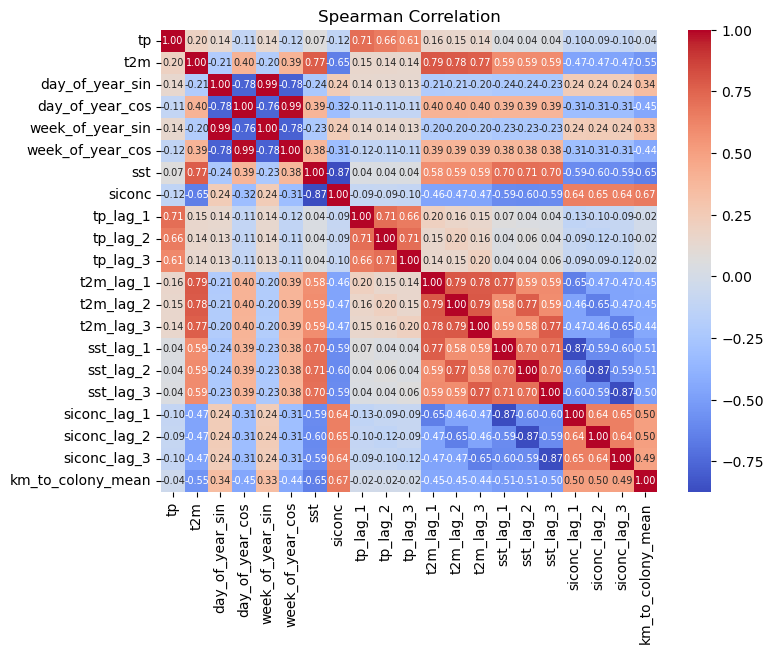

100%|██████████| 50/50 [02:26<00:00,  2.92s/trial, best loss: 187284.50285265094]
Best Hyperparameters: {'max_depth': 0, 'max_features': 2, 'min_samples_leaf': 0.010132692447442974, 'min_samples_split': 0.09987009251309806, 'n_estimators': 0}
Random Forest Test RMSE: 129.527
Random Forest Average R^2 Score: 0.644
             Feature  Importance
6                sst    0.419069
3    day_of_year_cos    0.387738
5   week_of_year_cos    0.147123
12         t2m_lag_2    0.018235
7             siconc    0.013979
2    day_of_year_sin    0.009443
15         sst_lag_2    0.002077
14         sst_lag_1    0.001973
18      siconc_lag_2    0.000167
13         t2m_lag_3    0.000144
17      siconc_lag_1    0.000053
0                 tp    0.000000
16         sst_lag_3    0.000000
10          tp_lag_3    0.000000
11         t2m_lag_1    0.000000
1                t2m    0.000000
9           tp_lag_2    0.000000
8           tp_lag_1    0.000000
4   week_of_year_sin    0.000000
19      siconc_lag_3    0

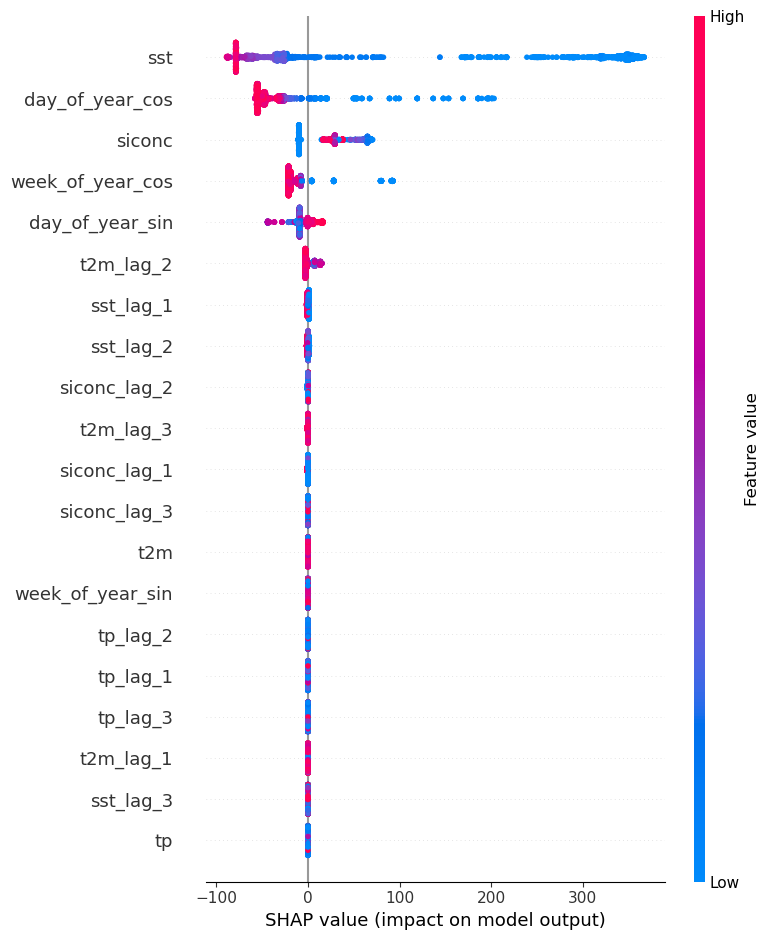

In [11]:
run_model_rf(penguin_df)

#### XGBoost

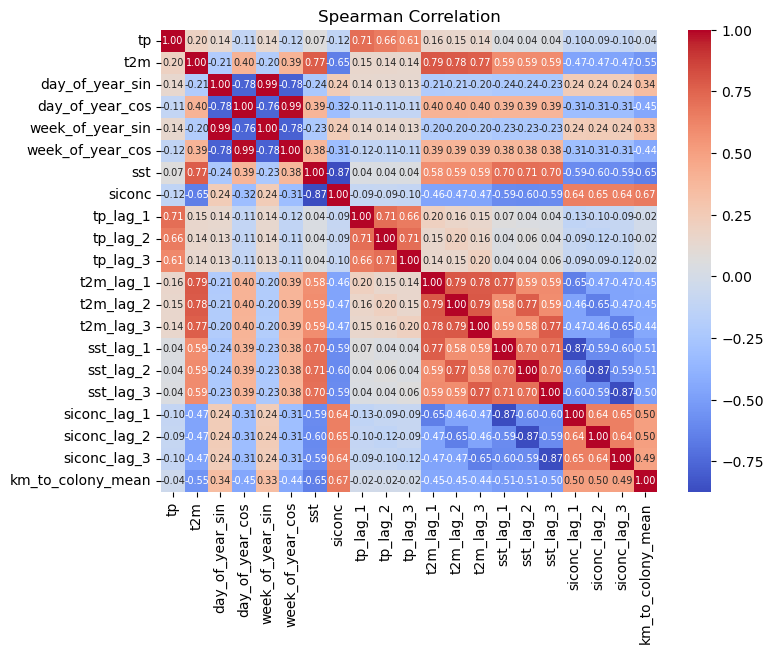

100%|██████████| 50/50 [01:05<00:00,  1.32s/trial, best loss: 176274.34347541138]
Best Hyperparameters: {'colsample_bytree': 0.7216158289842709, 'gamma': 0.25340305084410664, 'learning_rate': 0.012932689908125948, 'max_depth': 0, 'min_child_weight': 5.54241873825957, 'n_estimators': 0, 'subsample': 0.5561332680874085}
XGBoost Test RMSE: 124.034
XGBoost Average R^2 Score: 0.674
             Feature  Importance
6                sst    0.133623
5   week_of_year_cos    0.129793
3    day_of_year_cos    0.104894
7             siconc    0.073203
12         t2m_lag_2    0.063411
16         sst_lag_3    0.062085
1                t2m    0.059437
13         t2m_lag_3    0.046701
14         sst_lag_1    0.045774
15         sst_lag_2    0.038222
11         t2m_lag_1    0.036814
2    day_of_year_sin    0.034032
9           tp_lag_2    0.030143
17      siconc_lag_1    0.027427
4   week_of_year_sin    0.025688
10          tp_lag_3    0.024069
0                 tp    0.023224
8           tp_lag_1    0.

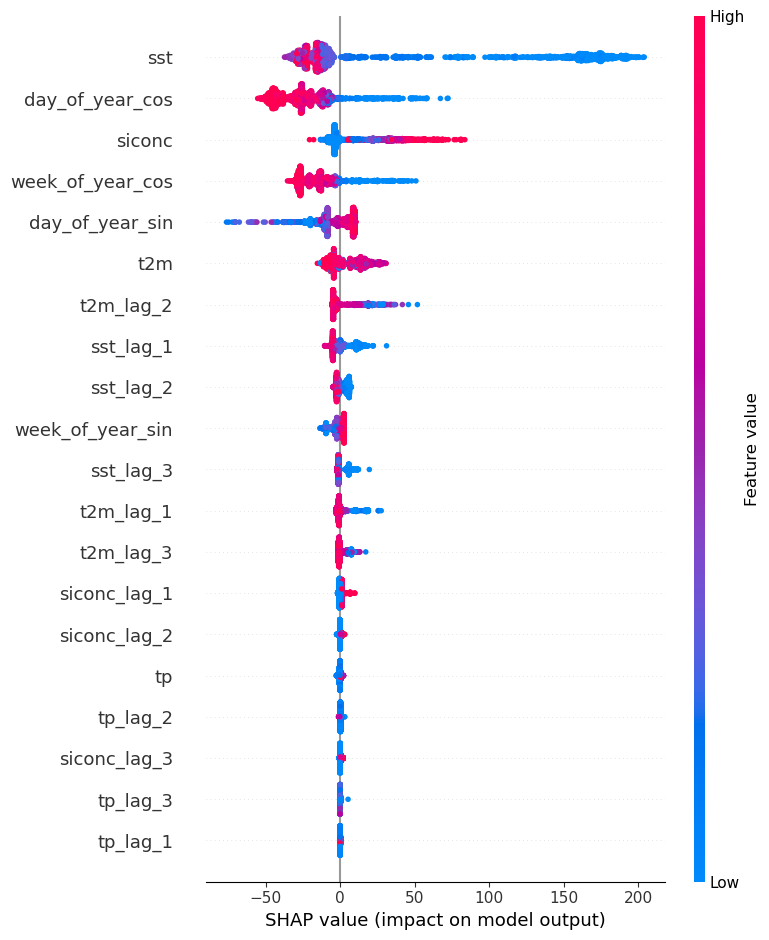

In [43]:
run_model_xgb(penguin_df)

### Adelie

#### Random Forest

C:\Users\eduar\AppData\Local\Temp\ipykernel_25036\812624305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_gmt'] = pd.to_datetime(df['date_gmt'])


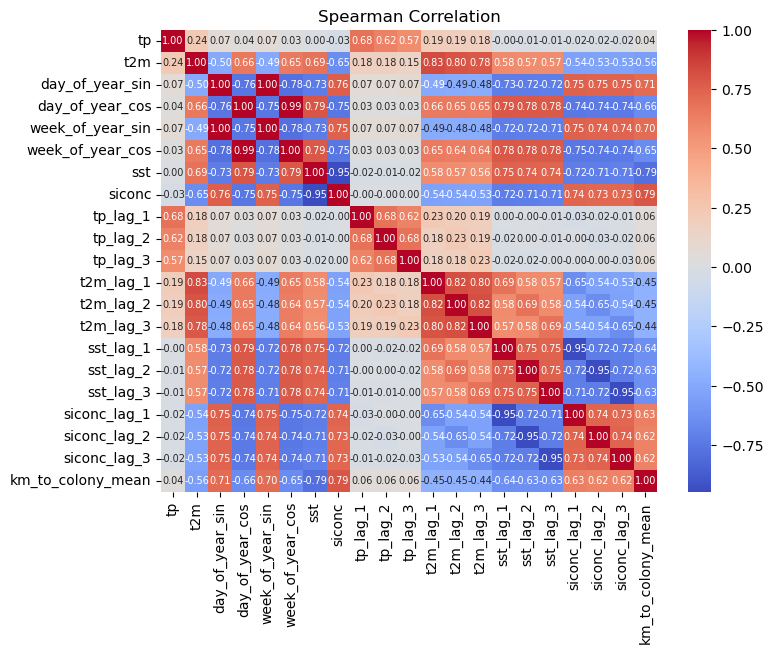

100%|██████████| 50/50 [00:50<00:00,  1.01s/trial, best loss: 39570.42347231576]
Best Hyperparameters: {'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 0.0981703917249216, 'min_samples_split': 0.03724635354052626, 'n_estimators': 0}
Random Forest Test RMSE: 82.939
Random Forest Average R^2 Score: 0.798
             Feature  Importance
6                sst    0.254027
7             siconc    0.179872
2    day_of_year_sin    0.150468
4   week_of_year_sin    0.092143
16         sst_lag_3    0.074049
15         sst_lag_2    0.064533
14         sst_lag_1    0.060944
17      siconc_lag_1    0.037329
5   week_of_year_cos    0.027902
3    day_of_year_cos    0.026575
19      siconc_lag_3    0.017659
1                t2m    0.008994
12         t2m_lag_2    0.001813
18      siconc_lag_2    0.001651
9           tp_lag_2    0.000585
13         t2m_lag_3    0.000505
10          tp_lag_3    0.000370
11         t2m_lag_1    0.000313
0                 tp    0.000141
8           tp_lag_1    0.000

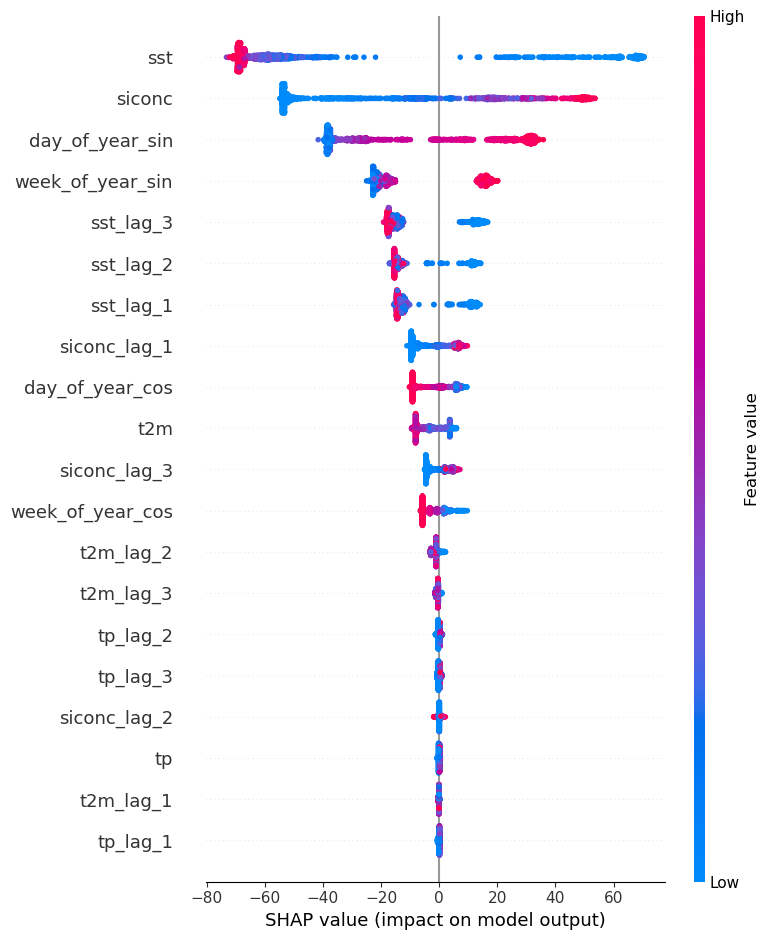

In [44]:
run_model_rf(adelie)

#### XGBoost

C:\Users\eduar\AppData\Local\Temp\ipykernel_25036\812624305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_gmt'] = pd.to_datetime(df['date_gmt'])


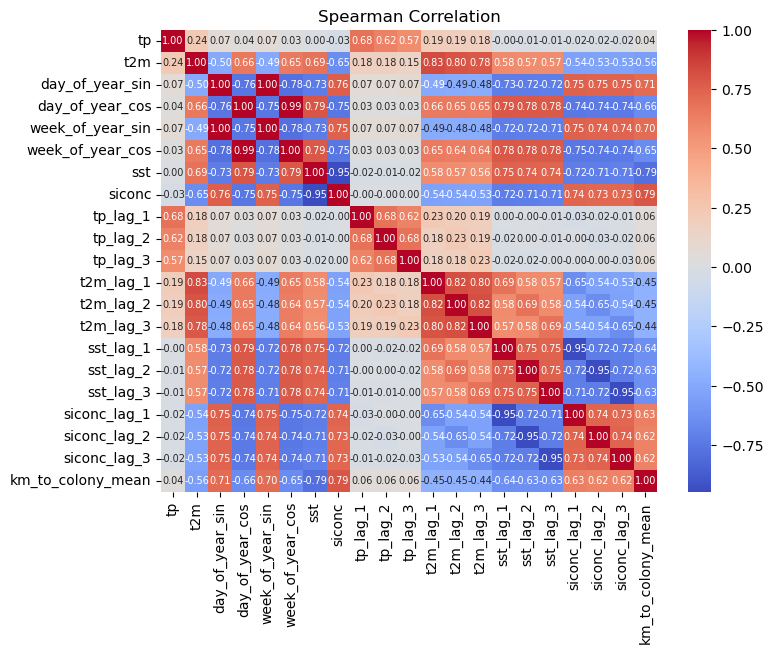

100%|██████████| 50/50 [00:53<00:00,  1.07s/trial, best loss: 38972.735191963395]
Best Hyperparameters: {'colsample_bytree': 0.9207223346620927, 'gamma': 2.1058350037393523, 'learning_rate': 0.01265463804368359, 'max_depth': 1, 'min_child_weight': 7.0211213438985105, 'n_estimators': 0, 'subsample': 0.7912275817657123}
XGBoost Test RMSE: 104.315
XGBoost Average R^2 Score: 0.681
             Feature  Importance
6                sst    0.481838
2    day_of_year_sin    0.084356
7             siconc    0.057446
5   week_of_year_cos    0.047728
4   week_of_year_sin    0.041965
1                t2m    0.035703
3    day_of_year_cos    0.031037
19      siconc_lag_3    0.025686
18      siconc_lag_2    0.024057
13         t2m_lag_3    0.023784
0                 tp    0.022513
17      siconc_lag_1    0.019082
12         t2m_lag_2    0.018513
11         t2m_lag_1    0.016622
14         sst_lag_1    0.015348
16         sst_lag_3    0.013977
10          tp_lag_3    0.013899
15         sst_lag_2    0.

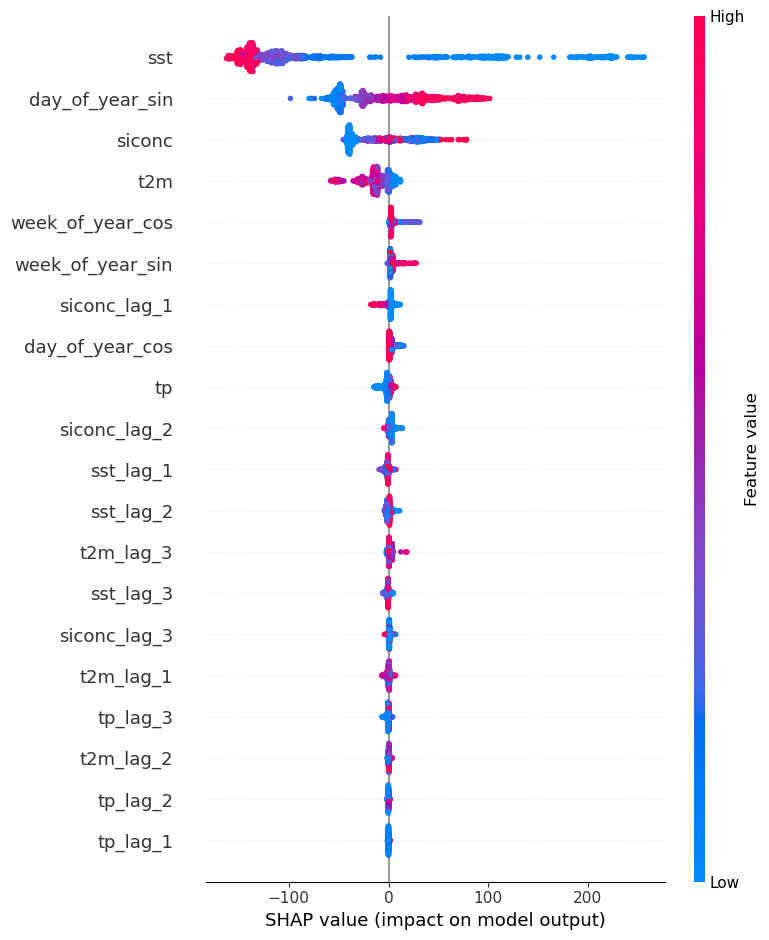

In [45]:
run_model_xgb(adelie)

### Chinstrap

#### Random Forest

C:\Users\eduar\AppData\Local\Temp\ipykernel_12152\812624305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_gmt'] = pd.to_datetime(df['date_gmt'])


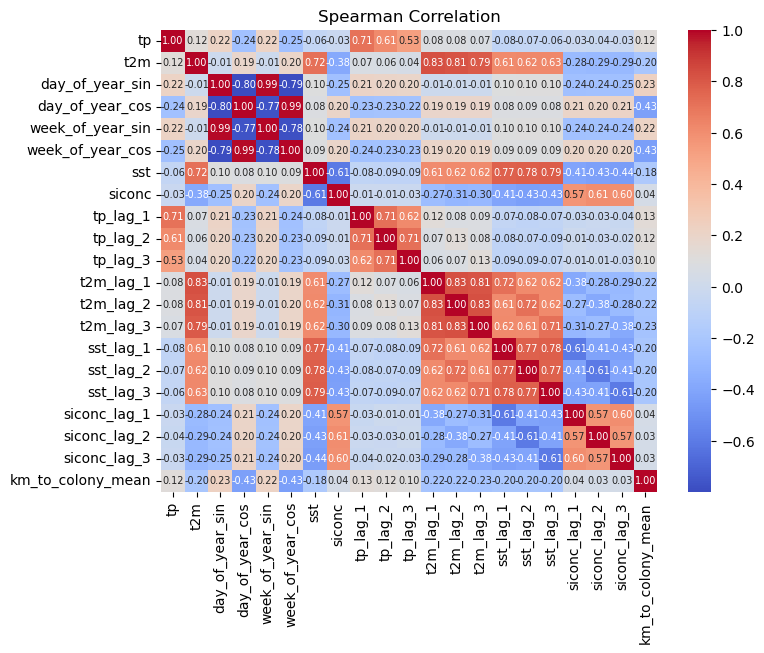

100%|██████████| 50/50 [01:27<00:00,  1.74s/trial, best loss: 473068.5797795847]
Best Hyperparameters: {'max_depth': 0, 'max_features': 2, 'min_samples_leaf': 0.010846940607860824, 'min_samples_split': 0.046200488330137596, 'n_estimators': 3}
Random Forest Test RMSE: 18.671
Random Forest Average R^2 Score: 0.004
             Feature    Importance
3    day_of_year_cos  7.925143e-01
2    day_of_year_sin  9.676537e-02
6                sst  3.121186e-02
7             siconc  2.231238e-02
5   week_of_year_cos  2.177650e-02
15         sst_lag_2  1.345087e-02
0                 tp  6.264821e-03
4   week_of_year_sin  5.372909e-03
12         t2m_lag_2  1.900552e-03
16         sst_lag_3  1.733177e-03
1                t2m  1.558200e-03
13         t2m_lag_3  1.401316e-03
14         sst_lag_1  1.154293e-03
11         t2m_lag_1  1.039158e-03
10          tp_lag_3  7.868955e-04
19      siconc_lag_3  3.118144e-04
8           tp_lag_1  2.412342e-04
9           tp_lag_2  2.043277e-04
18      siconc_lag_2 

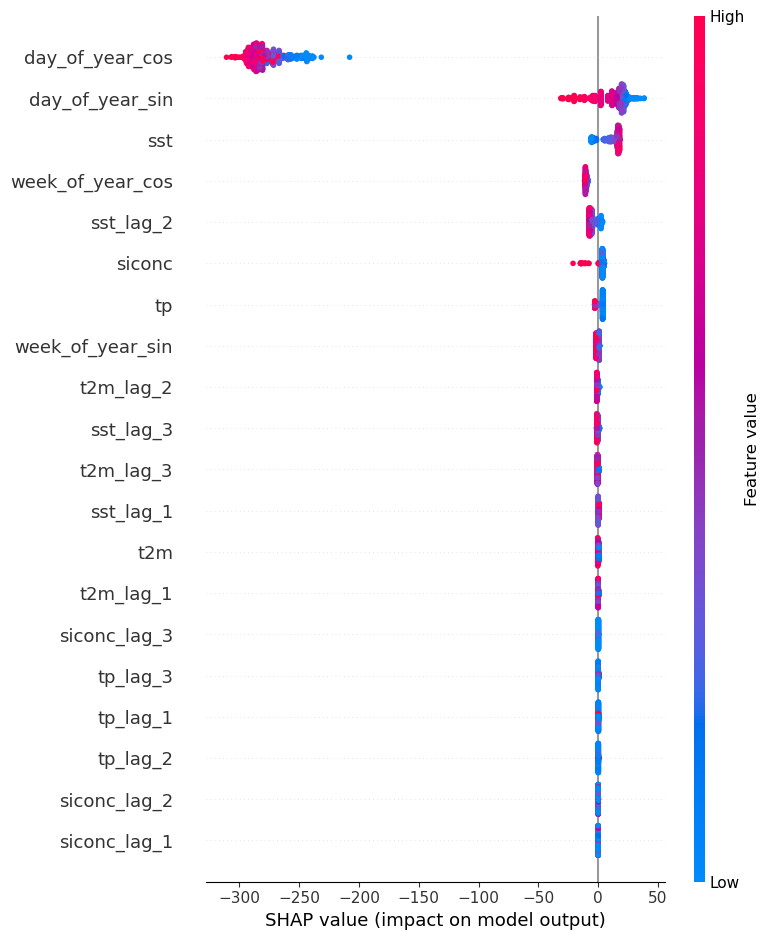

In [13]:
run_model_rf(chinstrap)

#### XGboost

C:\Users\eduar\AppData\Local\Temp\ipykernel_25036\812624305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_gmt'] = pd.to_datetime(df['date_gmt'])


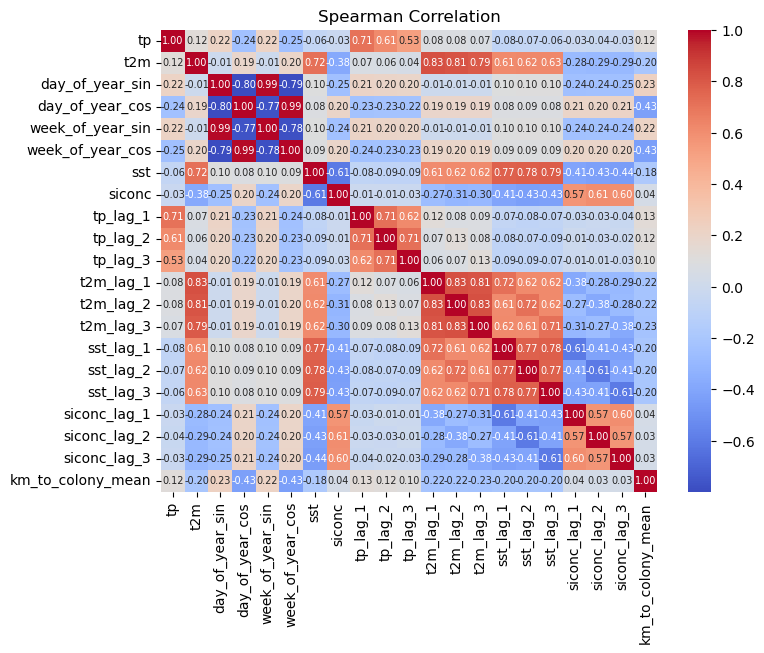

100%|██████████| 50/50 [00:39<00:00,  1.25trial/s, best loss: 484653.8105187025] 
Best Hyperparameters: {'colsample_bytree': 0.6621698600009251, 'gamma': 3.9000740469050563, 'learning_rate': 0.011391031451367665, 'max_depth': 1, 'min_child_weight': 5.8839486478288, 'n_estimators': 1, 'subsample': 0.8271249671733598}
XGBoost Test RMSE: 55.592
XGBoost Average R^2 Score: -7.831
             Feature  Importance
5   week_of_year_cos    0.282453
3    day_of_year_cos    0.197917
14         sst_lag_1    0.063311
4   week_of_year_sin    0.058787
2    day_of_year_sin    0.037307
7             siconc    0.034351
6                sst    0.032088
13         t2m_lag_3    0.031595
15         sst_lag_2    0.031563
11         t2m_lag_1    0.028992
17      siconc_lag_1    0.027251
0                 tp    0.026375
12         t2m_lag_2    0.025307
19      siconc_lag_3    0.024718
18      siconc_lag_2    0.021016
1                t2m    0.020954
10          tp_lag_3    0.016555
8           tp_lag_1    0.01

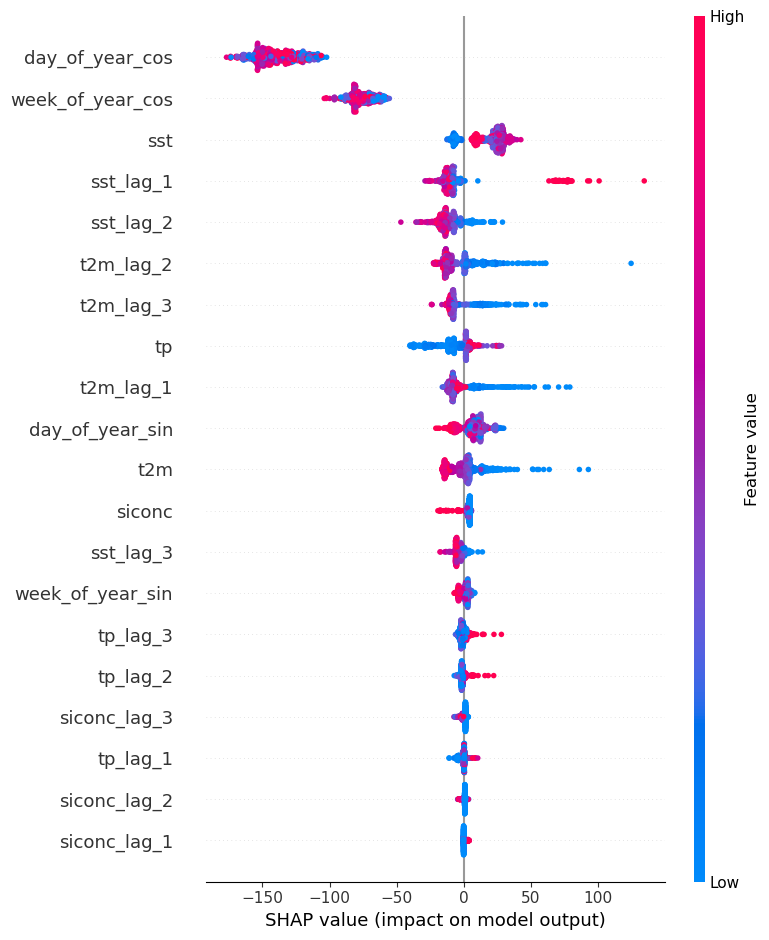

In [46]:
run_model_xgb(chinstrap)

### Gentoo

#### Random Forest

C:\Users\eduar\AppData\Local\Temp\ipykernel_12152\812624305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_gmt'] = pd.to_datetime(df['date_gmt'])


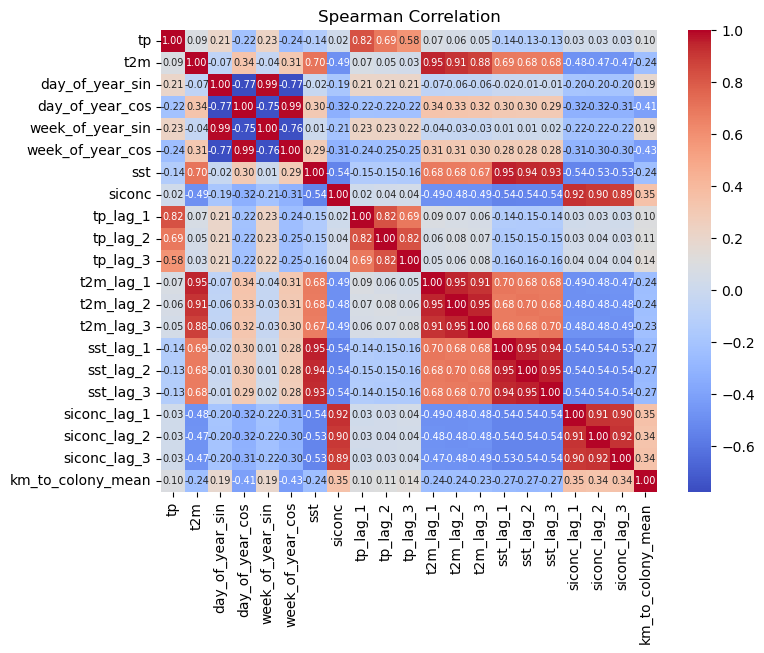

100%|██████████| 50/50 [00:37<00:00,  1.34trial/s, best loss: 855.726047962874] 
Best Hyperparameters: {'max_depth': 0, 'max_features': 2, 'min_samples_leaf': 0.010132692447442974, 'min_samples_split': 0.09987009251309806, 'n_estimators': 0}
Random Forest Test RMSE: 18.145
Random Forest Average R^2 Score: -0.457
             Feature  Importance
6                sst    0.988844
5   week_of_year_cos    0.003422
4   week_of_year_sin    0.001911
3    day_of_year_cos    0.001141
16         sst_lag_3    0.001065
1                t2m    0.000879
2    day_of_year_sin    0.000874
15         sst_lag_2    0.000795
14         sst_lag_1    0.000525
12         t2m_lag_2    0.000321
8           tp_lag_1    0.000087
0                 tp    0.000072
10          tp_lag_3    0.000029
11         t2m_lag_1    0.000021
9           tp_lag_2    0.000013
13         t2m_lag_3    0.000002
7             siconc    0.000000
17      siconc_lag_1    0.000000
18      siconc_lag_2    0.000000
19      siconc_lag_3    0.

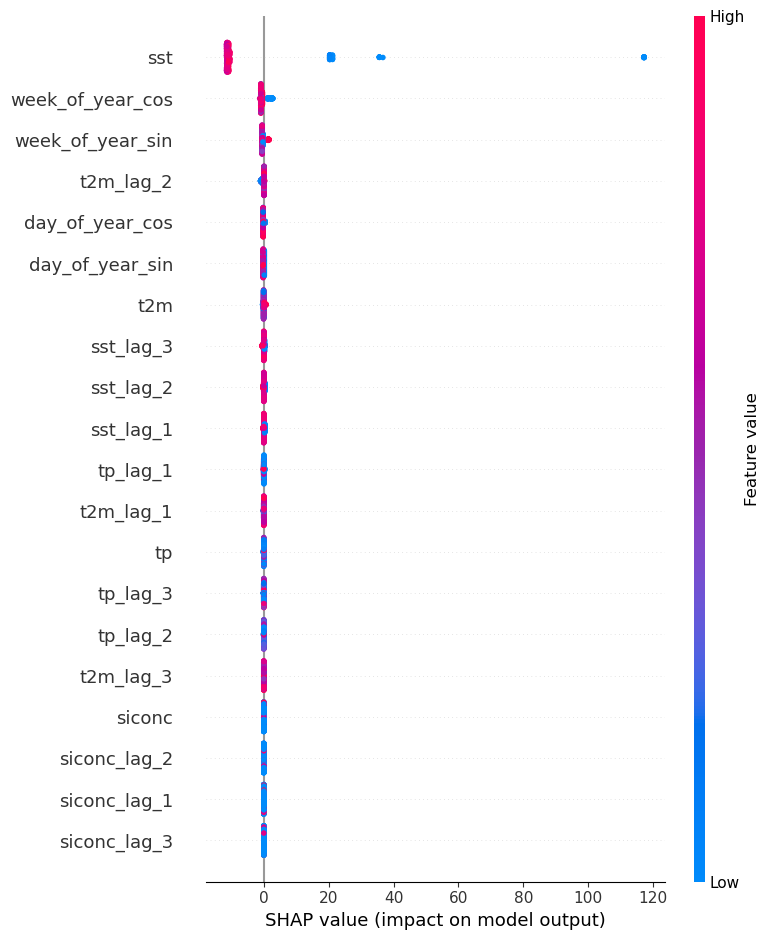

In [14]:
run_model_rf(gentoo)

#### XGBoost

C:\Users\eduar\AppData\Local\Temp\ipykernel_25036\812624305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_gmt'] = pd.to_datetime(df['date_gmt'])


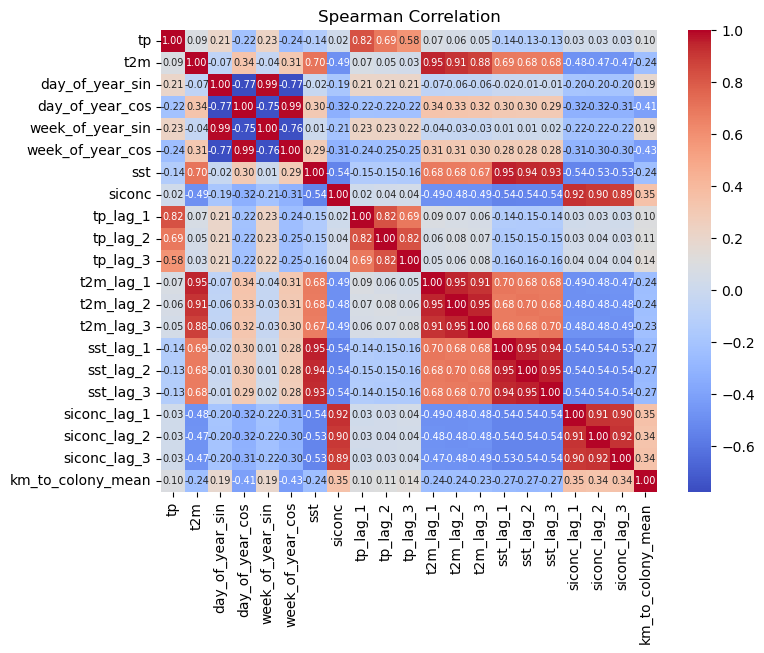

100%|██████████| 50/50 [00:29<00:00,  1.68trial/s, best loss: 810.4014288738169]
Best Hyperparameters: {'colsample_bytree': 0.6746284734176358, 'gamma': 4.967030128376157, 'learning_rate': 0.17630368113106493, 'max_depth': 3, 'min_child_weight': 1.486700869997656, 'n_estimators': 1, 'subsample': 0.8616492018371803}
XGBoost Test RMSE: 16.158
XGBoost Average R^2 Score: -0.155
             Feature  Importance
5   week_of_year_cos    0.695897
6                sst    0.121560
19      siconc_lag_3    0.047196
18      siconc_lag_2    0.028377
1                t2m    0.020422
7             siconc    0.015461
17      siconc_lag_1    0.010655
11         t2m_lag_1    0.007502
4   week_of_year_sin    0.007018
2    day_of_year_sin    0.006196
15         sst_lag_2    0.005000
9           tp_lag_2    0.004703
12         t2m_lag_2    0.004698
13         t2m_lag_3    0.004523
10          tp_lag_3    0.004404
8           tp_lag_1    0.004083
3    day_of_year_cos    0.003992
0                 tp    0.003

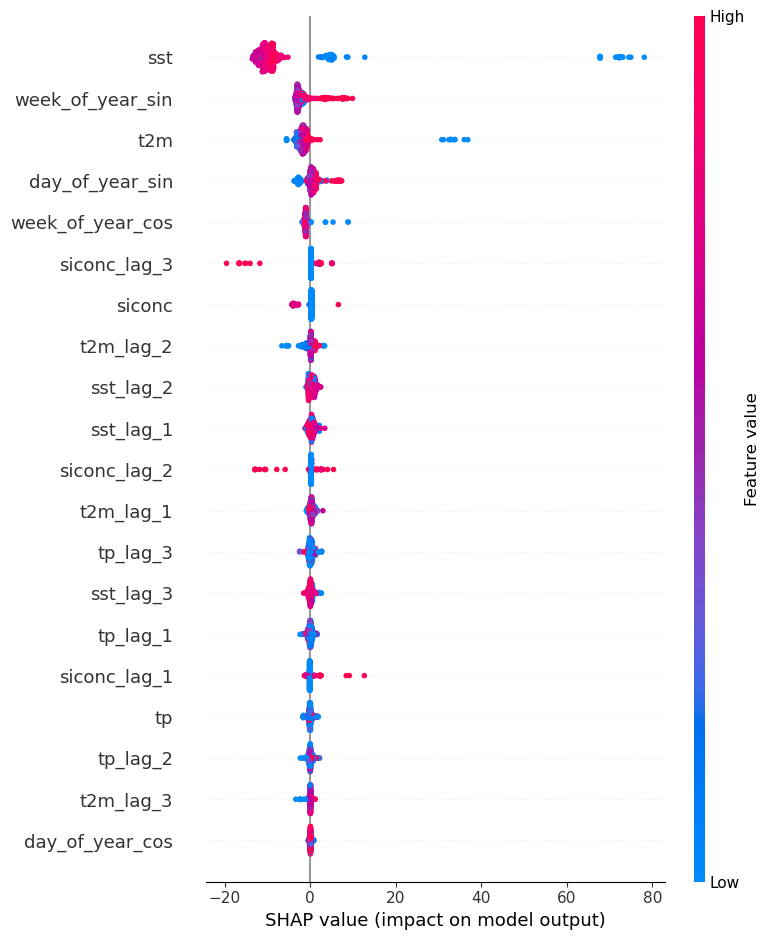

In [47]:
run_model_xgb(gentoo)